In [1]:
!pip install pydriller pandas GitPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.6 MB/s eta 0:00:00


In [17]:
# !pip install pydriller pandas GitPython

import os
import pandas as pd
import difflib
from pydriller import Repository

def clean_diff(diff_text):
    if diff_text is None: return ""
    diff_text = diff_text.lstrip().rstrip()
    diff_text = diff_text.replace(" ", "")
    diff_text = diff_text.replace("\n", "")
    return diff_text

def analyze_repository(repo_url):
    repo_name = repo_url.split('/')[-1]
    print(f"Analyzing repository: {repo_name}")

    data = []

    try:
        for commit in Repository(repo_url, only_no_merge=True).traverse_commits():

            parent_commit_hex = 'N/A'
            if commit.parents:
                parent = commit.parents[0]

                if hasattr(parent, 'hash'):
                    parent_commit_hex = parent.hash
                else:
                    parent_commit_hex = str(parent)

            for modified_file in commit.modified_files:
                old_path = modified_file.old_path or 'N/A'
                new_path = modified_file.new_path or 'N/A'
                old_content = modified_file.source_code_before or ''
                new_content = modified_file.source_code or ''
                diff_myers = modified_file.diff

                diff_hist_lines = difflib.unified_diff(
                    old_content.splitlines(), new_content.splitlines(),
                    fromfile=old_path, tofile=new_path, n=0
                )
                diff_hist = "\n".join(list(diff_hist_lines))

                at_position = diff_hist.find('@@')
                if at_position != -1:
                    diff_hist = diff_hist[at_position:]

                cleaned_diff_myers = clean_diff(diff_myers)
                cleaned_diff_hist = clean_diff(diff_hist)
                discrepancy = 'Yes' if cleaned_diff_myers != cleaned_diff_hist else 'No'
                data.append({
                    'old_file_path': old_path, 'new_file_path': new_path,
                    'commit_SHA': commit.hash, 'parent_commit_SHA': parent_commit_hex,
                    'commit_message': commit.msg, 'diff_myers': diff_myers,
                    'diff_hist': diff_hist, 'Discrepancy': discrepancy
                })

    except Exception as e:
        print(f"Error processing {repo_url}: {e}")

    df = pd.DataFrame(data)
    if not df.empty:
        output_path = f'{repo_name}_commits.csv'
        df.to_csv(output_path, index=False, encoding='utf-8', errors='replace')
        print(f"Saved data for {repo_name} to {output_path}")
    return df

if __name__ == "__main__":
    repo_urls = [
        'https://github.com/vllm-project/vllm',
        'https://github.com/psf/requests',
        'https://github.com/oraios/serena'
    ]
    all_dataframes = []
    for url in repo_urls:
        repo_df = analyze_repository(url)
        if not repo_df.empty:
            all_dataframes.append(repo_df)

    if all_dataframes:
        consolidated_df = pd.concat(all_dataframes, ignore_index=True)
        consolidated_df.to_csv('consolidated_dataset.csv', index=False, encoding='utf-8', errors='replace')
        print("\nConsolidated dataset saved to consolidated_dataset.csv")
    else:
        print("\nNo data was collected from any repository.")

Analyzing repository: vllm
Error processing https://github.com/vllm-project/vllm: SHA b'34c31c0af8fc975140b8c85548fefa1eb7f523e4' could not be resolved, git returned: b'34c31c0af8fc975140b8c85548fefa1eb7f523e4 missing'
Saved data for vllm to vllm_commits.csv
Analyzing repository: requests
Saved data for requests to requests_commits.csv
Analyzing repository: serena
Saved data for serena to serena_commits.csv

Consolidated dataset saved to consolidated_dataset.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def categorize_file(file_path):
    """
    Categorizes a file based on its path.
    """
    if not isinstance(file_path, str):
        return 'Other'

    file_path = file_path.lower()
    if ('test' in file_path) or ('spec' in file_path) or ('_test.py' in file_path):
        return 'Test Code'
    elif file_path.endswith(('.c', '.cpp', '.java', '.py', '.js', '.ts', '.go', '.html', '.css', '.json')):
        return 'Source Code'
    elif 'readme' in file_path:
        return 'README'
    elif 'license' in file_path:
        return 'LICENSE'
    else:
        return 'Other'

In [4]:
# Assuming the CSV is named 'consolidated_dataset.csv'
input_file = '/content/serena_commits.csv'
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} was not found. Please run the data collection script first.")
else:
    df = pd.read_csv(input_file)
    print("Dataset loaded successfully.")

    # Apply file categorization
    df['file_type'] = df['new_file_path'].apply(categorize_file)

    # Filter for mismatches and get counts per file type
    # Since your current script duplicates the diffs, this count will be zero.
    mismatches_df = df[df['Discrepancy'] == 'Yes']
    mismatch_counts = mismatches_df['file_type'].value_counts()

    # Print the statistics
    print("\n--- Mismatch Statistics ---")
    print("# Mismatches for Source Code files:", mismatch_counts.get('Source Code', 0))
    print("# Mismatches for Test Code files:", mismatch_counts.get('Test Code', 0))
    print("# Mismatches for README files:", mismatch_counts.get('README', 0))
    print("# Mismatches for LICENSE files:", mismatch_counts.get('LICENSE', 0))
    print("\nTotal mismatches:", len(mismatches_df))

Dataset loaded successfully.

--- Mismatch Statistics ---
# Mismatches for Source Code files: 1543
# Mismatches for Test Code files: 421
# Mismatches for README files: 146
# Mismatches for LICENSE files: 1

Total mismatches: 2612



Plot saved to mismatch_plot_serena.png


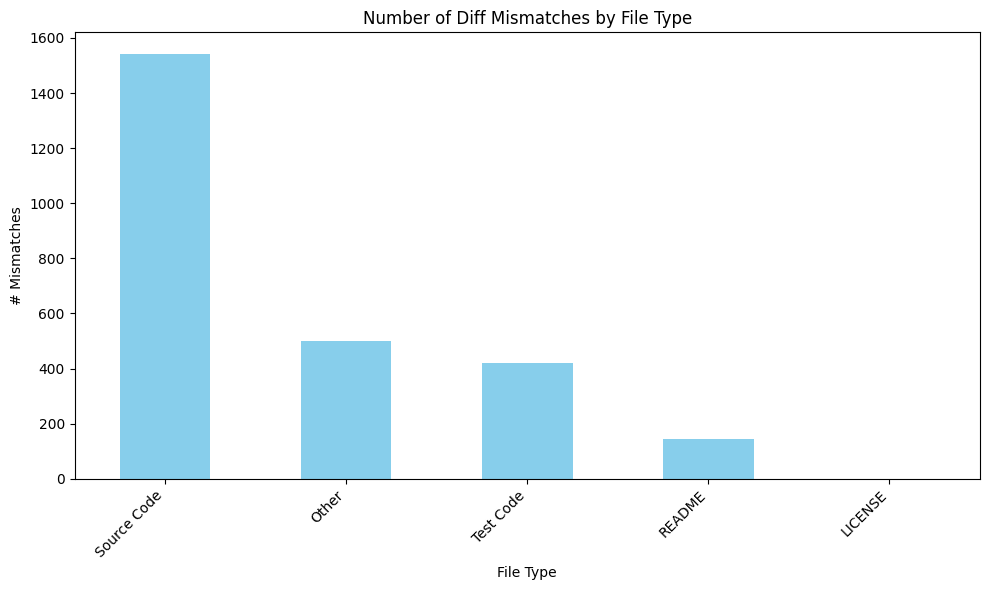

In [5]:
# Create the plot
plt.figure(figsize=(10, 6))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Diff Mismatches by File Type')
plt.xlabel('File Type')
plt.ylabel('# Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_plot_path = 'mismatch_plot_serena.png'
plt.savefig(output_plot_path)
print(f"\nPlot saved to {output_plot_path}")
plt.show()

In [38]:
input_file = '/content/requests_commits.csv'
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} was not found. Please run the data collection script first.")
else:
    df = pd.read_csv(input_file)
    print("Dataset loaded successfully.")

    # Apply file categorization
    df['file_type'] = df['new_file_path'].apply(categorize_file)

    mismatches_df = df[df['Discrepancy'] == 'Yes']
    mismatch_counts = mismatches_df['file_type'].value_counts()

    # Print the statistics
    print("\n--- Mismatch Statistics ---")
    print("# Mismatches for Source Code files:", mismatch_counts.get('Source Code', 0))
    print("# Mismatches for Test Code files:", mismatch_counts.get('Test Code', 0))
    print("# Mismatches for README files:", mismatch_counts.get('README', 0))
    print("# Mismatches for LICENSE files:", mismatch_counts.get('LICENSE', 0))
    print("\nTotal mismatches:", len(mismatches_df))
    print(f"\nToal Files Analysed: {len(df)}")
    print(f"\nPercentage of files with mismatch: {round(100 * len(mismatches_df)/len(df), 2)}%")

Dataset loaded successfully.

--- Mismatch Statistics ---
# Mismatches for Source Code files: 158
# Mismatches for Test Code files: 30
# Mismatches for README files: 10
# Mismatches for LICENSE files: 0

Total mismatches: 248

Toal Files Analysed: 7799

Percentage of files with mismatch: 3.18%



Plot saved to mismatch_plot_request.png


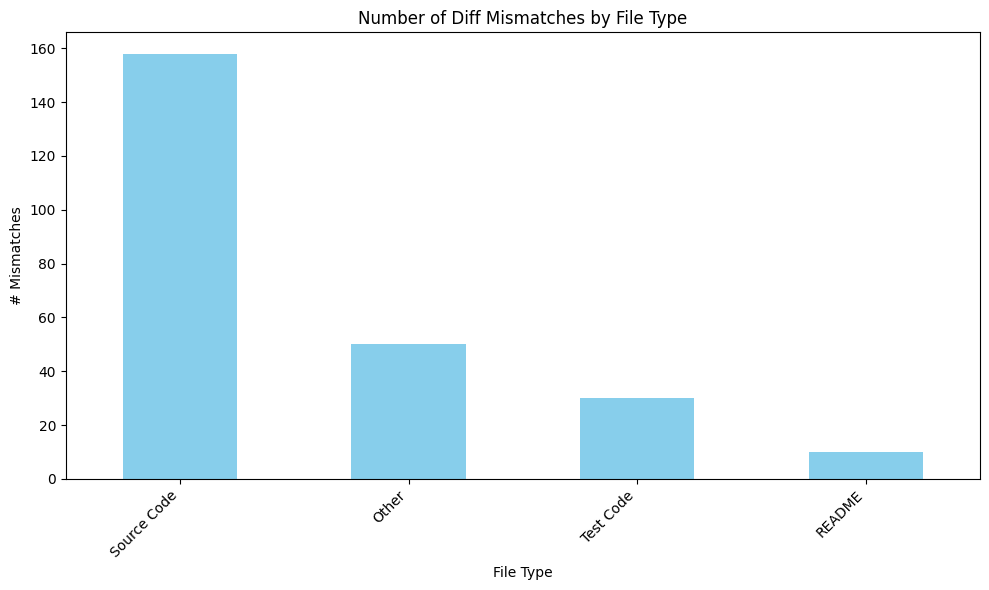

In [39]:
# Create the plot
plt.figure(figsize=(10, 6))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Diff Mismatches by File Type')
plt.xlabel('File Type')
plt.ylabel('# Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_plot_path = 'mismatch_plot_request.png'
plt.savefig(output_plot_path)
print(f"\nPlot saved to {output_plot_path}")
plt.show()

In [32]:

input_file = '/content/serena_commits.csv'
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} was not found. Please run the data collection script first.")
else:
    df = pd.read_csv(input_file)
    print("Dataset loaded successfully.")

    # Apply file categorization
    df['file_type'] = df['new_file_path'].apply(categorize_file)

    mismatches_df = df[df['Discrepancy'] == 'Yes']
    mismatch_counts = mismatches_df['file_type'].value_counts()

    # Print the statistics
    print("\n--- Mismatch Statistics ---")
    print("# Mismatches for Source Code files:", mismatch_counts.get('Source Code', 0))
    print("# Mismatches for Test Code files:", mismatch_counts.get('Test Code', 0))
    print("# Mismatches for README files:", mismatch_counts.get('README', 0))
    print("# Mismatches for LICENSE files:", mismatch_counts.get('LICENSE', 0))
    print("\nTotal mismatches:", len(mismatches_df))
    print(f"\nToal Files Analysed: {len(df)}")
    print(f"\nPercentage of files with mismatch: {round(100 * len(mismatches_df)/len(df), 2)}%")

Dataset loaded successfully.

--- Mismatch Statistics ---
# Mismatches for Source Code files: 104
# Mismatches for Test Code files: 14
# Mismatches for README files: 15
# Mismatches for LICENSE files: 1

Total mismatches: 144

Toal Files Analysed: 3061

Percentage of files with mismatch: 4.7%



Plot saved to mismatch_plot.png


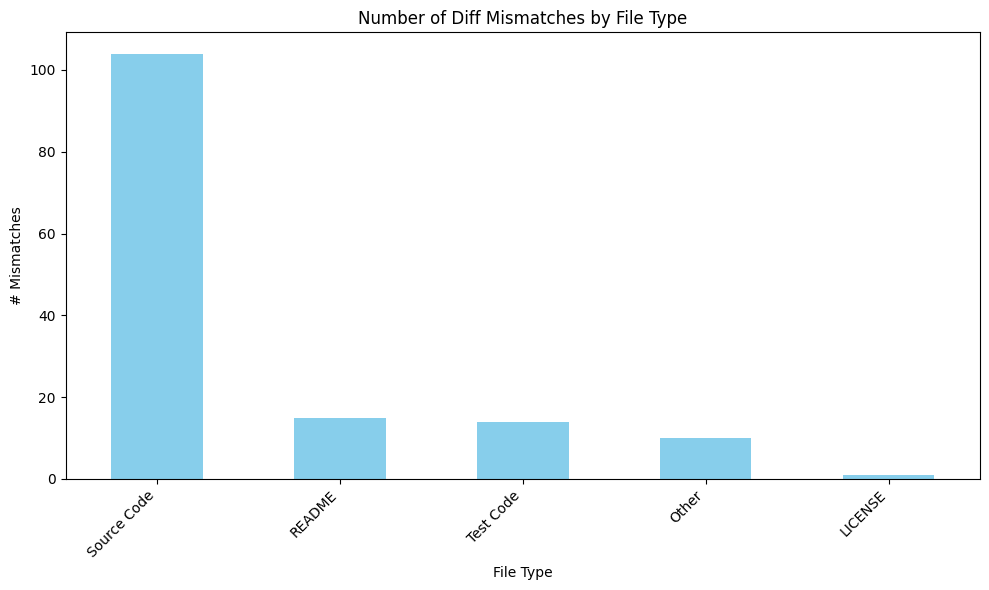

In [28]:
# Create the plot
plt.figure(figsize=(10, 6))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Diff Mismatches by File Type')
plt.xlabel('File Type')
plt.ylabel('# Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_plot_path = 'mismatch_plot_serena.png'
plt.savefig(output_plot_path)
print(f"\nPlot saved to {output_plot_path}")
plt.show()

In [43]:
input_file = '/content/vllm_commits.csv'
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} was not found. Please run the data collection script first.")
else:
    df = pd.read_csv(input_file)
    print("Dataset loaded successfully.")

    # Apply file categorization
    df['file_type'] = df['new_file_path'].apply(categorize_file)

    mismatches_df = df[df['Discrepancy'] == 'Yes']
    mismatch_counts = mismatches_df['file_type'].value_counts()

    # Print the statistics
    print("\n--- Mismatch Statistics ---")
    print("# Mismatches for Source Code files:", mismatch_counts.get('Source Code', 0))
    print("# Mismatches for Test Code files:", mismatch_counts.get('Test Code', 0))
    print("# Mismatches for README files:", mismatch_counts.get('README', 0))
    print("# Mismatches for LICENSE files:", mismatch_counts.get('LICENSE', 0))
    print("\nTotal mismatches:", len(mismatches_df))
    print(f"\nToal Files Analysed: {len(df)}")
    print(f"\nPercentage of files with mismatch: {round(100 * len(mismatches_df)/len(df), 2)}%")

Dataset loaded successfully.

--- Mismatch Statistics ---
# Mismatches for Source Code files: 961
# Mismatches for Test Code files: 268
# Mismatches for README files: 8
# Mismatches for LICENSE files: 0

Total mismatches: 1477

Toal Files Analysed: 35904

Percentage of files with mismatch: 4.11%



Plot saved to mismatch_plot_vllm.png


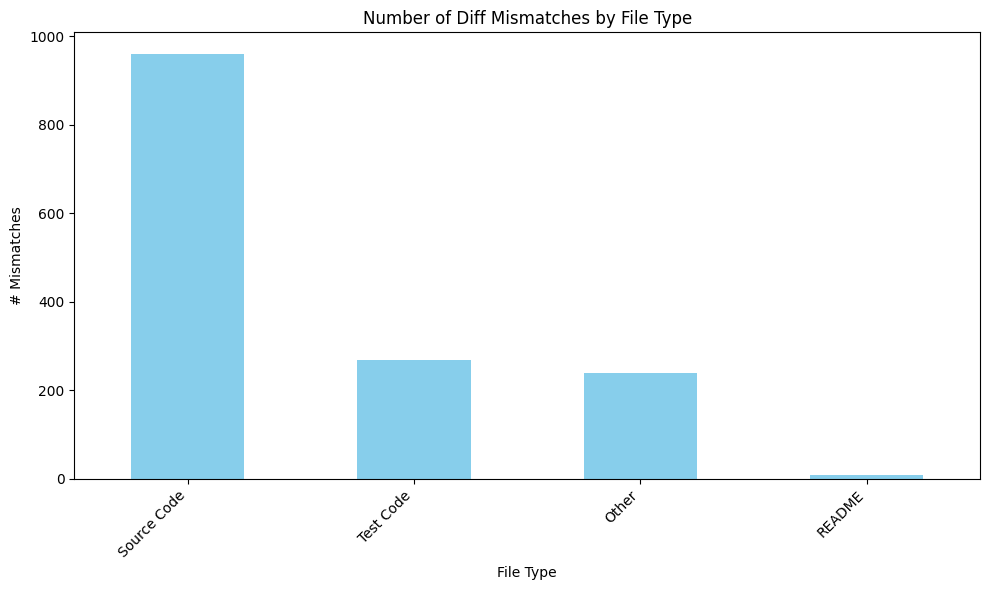

In [44]:
# Create the plot
plt.figure(figsize=(10, 6))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Diff Mismatches by File Type')
plt.xlabel('File Type')
plt.ylabel('# Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_plot_path = 'mismatch_plot_vllm.png'
plt.savefig(output_plot_path)
print(f"\nPlot saved to {output_plot_path}")
plt.show()

In [40]:
input_file = '/content/consolidated_dataset.csv'
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} was not found. Please run the data collection script first.")
else:
    df = pd.read_csv(input_file)
    print("Dataset loaded successfully.")

    # Apply file categorization
    df['file_type'] = df['new_file_path'].apply(categorize_file)

    mismatches_df = df[df['Discrepancy'] == 'Yes']
    mismatch_counts = mismatches_df['file_type'].value_counts()

    # Print the statistics
    print("\n--- Mismatch Statistics ---")
    print("# Mismatches for Source Code files:", mismatch_counts.get('Source Code', 0))
    print("# Mismatches for Test Code files:", mismatch_counts.get('Test Code', 0))
    print("# Mismatches for README files:", mismatch_counts.get('README', 0))
    print("# Mismatches for LICENSE files:", mismatch_counts.get('LICENSE', 0))
    print("\nTotal mismatches:", len(mismatches_df))
    print(f"\nToal Files Analysed: {len(df)}")
    print(f"\nPercentage of files with mismatch: {round(100 * len(mismatches_df)/len(df), 2)}%")

Dataset loaded successfully.

--- Mismatch Statistics ---
# Mismatches for Source Code files: 1223
# Mismatches for Test Code files: 312
# Mismatches for README files: 33
# Mismatches for LICENSE files: 1

Total mismatches: 1869

Toal Files Analysed: 46764

Percentage of files with mismatch: 4.0%



Plot saved to mismatch_plot.png


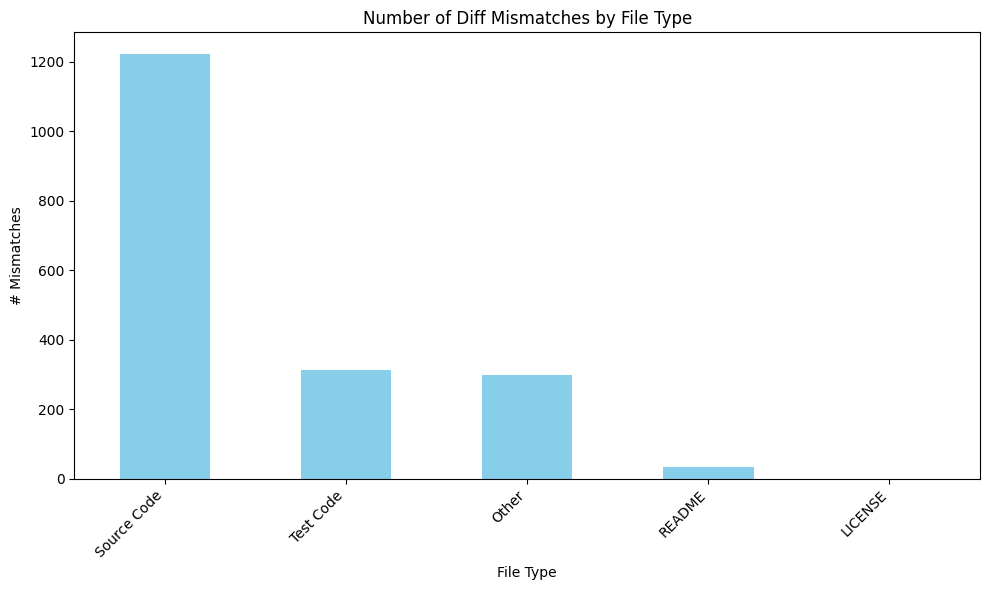

In [41]:
# Create the plot
plt.figure(figsize=(10, 6))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Diff Mismatches by File Type')
plt.xlabel('File Type')
plt.ylabel('# Mismatches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_plot_path = 'mismatch_plot.png'
plt.savefig(output_plot_path)
print(f"\nPlot saved to {output_plot_path}")
plt.show()